In [1]:
import numpy as np
import dimod
import xtools as xt
import matplotlib.pyplot as plt
from openjij import SQASampler

In [2]:
from atm.flight.generator import ScenarioGenerator
from atm.separation import recat
from atm.flight.flight import DUMMY_FLIGHT_RECAT

In [3]:
cf = xt.Config(dict(
    dt=10,
    num=30,
    scenario=dict(
        interval=60,
        window=300,
        mode="mix",
        standard="recat"
    )
))

In [4]:
gen = ScenarioGenerator(cf.scenario)


In [5]:
sep = recat.TBS

In [81]:
xs = np.arange(cf.num)

def calc_time_by_order(vols, separation, indices):
    past_vol = DUMMY_FLIGHT_RECAT
    past_time = DUMMY_FLIGHT_RECAT.ready

    assigned_times = []
    for idx in indices:
        vol = vols[idx]
        sep_time = separation(past_vol, vol)
        time = np.max([vol.ready, past_time + sep_time])
        assigned_times.append(time)

        past_vol = vol
        past_time = time

    return assigned_times

def gen_obj(vols, separation, penalty):
    def func(xs):
        times = calc_time_by_order(vols, separation, xs)

        delays = []
        num_violation = 0
        for idx in xs:
            vol = vols[idx]
            time = times[idx]
            delays.append(time - vol.ready)
            if time > vol.due:
                num_violation += 1
        return sum(delays) / len(vols) + num_violation * penalty

    return func

In [82]:
vols = gen(cf.num)

In [83]:
f = gen_obj(vols, sep, 100)
f(np.arange(len(vols)))


6267.98

In [84]:
class SequentialMetropolis:

    def __init__(self, objective, nx, T=1., swap_remote=False, seed=None, on_notebook=False):
        self.f = objective
        self.nx = nx
        self.T = T
        self._swap_remote = swap_remote
        self.rs = None
        self.seed(seed)
        self.on_notebook = on_notebook

        self.ec = None
        self.best_x = None

    def seed(self, seed=None):
        self.rs = np.random.RandomState(seed)
        return seed

    def swap(self, x):
        x_ = x.copy()
        if self._swap_remote:
            ixs = self.rs.choice(np.arange(len(x)), 2, replace=False)
            x_[ixs] = x[ixs[::-1]]
            return x_

        iter = self.rs.randint(len(x)-1)
        x_[iter:iter+2] = x[iter:iter+2][::-1]
        return x_

    def step(self, xc):
        xp = self.swap(xc)
        ep = self.f(xp)

        r = self.accept_prob(self.ec, ep)

        if ep < self.ec:
            self.best_x = xp.copy()

        if r > self.rs.rand():
            self.ec = ep
            return xp

        return xc

    def accept_prob(self, ec, ep):
        de = ep - ec
        # print(de, ep, ec)
        r = np.exp(-de / self.T)
        return np.min([1, r])

    def optimize(self, x0=None, e0=None, num_iter=10):
        xc = x0 if x0 is not None else np.arange(self.nx)
        self.ec = e0 if e0 is not None else self.f(xc)
        self.best_x = xc.copy()

        log = dict(step=[0], energy=[self.ec])

        for i in range(num_iter):
            xc = self.step(xc)
            log["step"].append(i+1)
            log["energy"].append(self.ec)

        return log

In [166]:
def retrieve_sampler(nq, separation, vols):
    def sample_by_qa(xs):
        # retrieve target range xs
        idx_retrieve = np.random.randint(0, len(xs)-nq)
        qxs = xs[idx_retrieve:idx_retrieve+nq]

        # build CQM
        cqm = dimod.ConstrainedQuadraticModel()

        # define variables
        qs = [
            [dimod.Binary(f"x_{i}_{j}") for j in range(nq)]
            for i in range(nq)
        ]

        # build objective
        cqm.set_objective(sum([
            sum([
                separation(vols[i], vols[i+1]) * qs[i][j] * qs[i][j+1]
                for j in range(nq-1) if i == j
            ]) for i in range(nq)
        ]))
        # constraints: unique select
        [cqm.add_constraint(sum([qs[i][j] for j in range(nq)]) == 1, label=f"h-select-{i}") for i in range(nq)]
        [cqm.add_constraint(sum([qs[i][j] for i in range(nq)]) == 1, label=f"v-select-{j}") for j in range(nq)]

        # convert to bqm

        bqm, invert = dimod.cqm_to_bqm(cqm, lagrange_multiplier=1)
        # sample
        sampler = SQASampler()
        sampleset = sampler.sample(bqm)
        sample = list(sampleset.first.sample.values())

        # invert sample
        sample = np.reshape(sample, (nq, nq))
        sample_order = np.argmax(sample, axis=1)

        # build proposed sample
        xs_ = xs.copy()
        xs_[idx_retrieve:idx_retrieve+nq] = qxs[sample_order]
        return xs_

    return sample_by_qa

In [147]:
cf = xt.Config(dict(
    dt=10,
    num=50,
    scenario=dict(
        interval=60,
        window=360,
        mode="mix",
        standard="recat"
    )
))
gen = ScenarioGenerator(cf.scenario)

In [150]:
Nq = 3
vio_penalty = 1000
vols = gen(cf.num)
vols = gen(5)

In [151]:
f = gen_obj(vols, sep, vio_penalty)

In [163]:
algo = SequentialMetropolis(f, len(vols), T=1)
algo.swap = retrieve_sampler(Nq, sep, vols)

In [164]:
log = algo.optimize(num_iter=300)
print(algo.best_x)

[0 2 1 3 4]


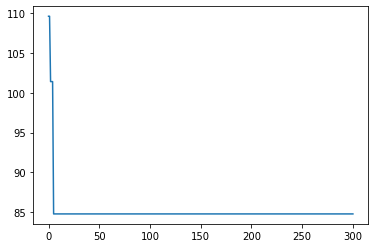

In [165]:
plt.plot(log["step"], log["energy"])
plt.show()

In [119]:
assigned_times = calc_time_by_order(vols, sep, algo.best_x)
retrieved_assigned_time = np.zeros_like(assigned_times)
for orig_idx, t in zip(algo.best_x, assigned_times):
    retrieved_assigned_time[orig_idx] = t
print(algo.best_x)
print(assigned_times)
print(retrieved_assigned_time)
df_vols = vols.to_dataframe()
df_vols["time"] = retrieved_assigned_time
df_vols

[0 2 1 3 4]
[122, 204, 279, 410, 508]
[122 279 204 410 508]


,code,ready,due,category,operation,time
0,VOL0001,122,482,F,A,122
1,VOL0002,128,488,E,D,279
2,VOL0003,204,564,D,A,204
3,VOL0004,354,714,F,D,410
4,VOL0005,470,830,F,A,508
